In [2]:
import pandas as pd

In [3]:
from pyspark import SparkContext, SparkConf
cf = SparkConf()
cf.set("spark.submit.deployMode","client")
sc = SparkContext.getOrCreate(cf)
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.appName("Python Spark SQL basic example") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/10 17:53:09 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/10 17:53:09 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/10 17:53:09 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/10 17:53:09 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [20]:
ad_df = spark.read.parquet("/shared/CS-GY-6513/projects/WildLife/processed-data-oct")
ad_df.printSchema()

root
 |-- url: string (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- image: string (nullable = true)
 |-- retrieved: string (nullable = true)
 |-- production_data: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- seller_type: string (nullable = true)
 |-- seller_url: string (nullable = true)
 |-- location: string (nullable = true)
 |-- ships to: string (nullable = true)
 |-- id: string (nullable = true)
 |-- loc_name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- country: string (nullable = true)
 |-- product: string (nullable = true)
 |-- label_product: string (nullable = true)
 |-- score_product: double (nullable = true)
 |-- label: d

In [4]:
#Geo distribution
from pyspark.sql import SparkSession

# Initialize a SparkSession
spark = SparkSession.builder.appName("ParquetReadExample").getOrCreate()

# Define the custom schema using DDL string
custom_schema = "location STRING, label DOUBLE"

# Read Parquet files with the specified schema
geo_df = spark.read.schema(custom_schema).parquet("/shared/CS-GY-6513/projects/WildLife/processed-data-oct")

# Rest of your code...
geo_df.createOrReplaceTempView("geo_view")
geo_df.show(20, truncate=False)

+-----------------------------+-----+
|location                     |label|
+-----------------------------+-----+
|Greystanes, NSW, AU          |0.0  |
|Orlando, Florida, US         |0.0  |
|Asheville, North Carolina, US|0.0  |
|East Setauket, New York, US  |0.0  |
|nanyang, CN                  |0.0  |
|Calp, ES                     |0.0  |
|Spokane, Washington, US      |1.0  |
|Bellmawr, New Jersey, US     |0.0  |
|Sayre, Pennsylvania, US      |1.0  |
|Brooklyn, New York, US       |0.0  |
|Havana, Illinois, US         |0.0  |
|Katy, Texas, US              |0.0  |
|Wilsonville, Oregon, US      |1.0  |
|nanyangshi, CN               |0.0  |
|å¹¿å·åž, CN                |0.0  |
|DongGuan,GuangDong, CN       |1.0  |
|Aurora, Colorado, US         |0.0  |
|Juneau, Alaska, US           |0.0  |
|Blaine, Washington, US       |1.0  |
|Marlow, GB                   |0.0  |
+-----------------------------+-----+
only showing top 20 rows



In [5]:
type(geo_df)

pyspark.sql.dataframe.DataFrame

In [6]:
geo_view = spark.sql("SELECT location, label FROM geo_view WHERE label = 1.0")
geo_view.show(20)

+--------------------+-----+
|            location|label|
+--------------------+-----+
|Spokane, Washingt...|  1.0|
|Sayre, Pennsylvan...|  1.0|
|Wilsonville, Oreg...|  1.0|
|DongGuan,GuangDon...|  1.0|
|Blaine, Washingto...|  1.0|
|        SHENZHEN, CN|  1.0|
|Wildwood, New Jer...|  1.0|
|Asheville, North ...|  1.0|
|Wilsonville, Oreg...|  1.0|
|Irvine, Californi...|  1.0|
|Fullerton, Califo...|  1.0|
|     Ho Chi Minh, VN|  1.0|
|       GuangZhou, CN|  1.0|
|Rowland Heights, ...|  1.0|
|Jasper, Missouri, US|  1.0|
|Wilsonville, Oreg...|  1.0|
|Sagamore, Massach...|  1.0|
|New York, New Yor...|  1.0|
|Merrillville, Ind...|  1.0|
|Sarasota, Florida...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [7]:
countries = spark.sql("""
    SELECT 
        location, 
        TRIM(split(location, ',')[SIZE(split(location, ',')) - 1]) AS country_code 
    FROM geo_view
""")
countries.createOrReplaceTempView("countries_view")

NameError: name 'countries_view' is not defined

In [8]:
country_count = spark.sql("""
    SELECT country_code,
    COUNT(*) as count
    FROM countries_view
    WHERE country_code is not NULL AND country_code = UPPER(country_code) AND LENGTH(country_code) = 2
    GROUP BY country_code
    HAVING count > 9
    ORDER BY count DESC
    """)
country_count.createOrReplaceTempView("country_count_view")
country_with_states = spark.sql("SELECT * FROM country_count_view")
country_with_states.show(20)

+------------+-----+
|country_code|count|
+------------+-----+
|          US| 9945|
|          GB| 1573|
|          NY| 1147|
|          CA| 1121|
|          CN|  920|
|          FL|  630|
|          DE|  549|
|          IT|  440|
|          FR|  419|
|          NL|  344|
|          TX|  342|
|          HK|  293|
|          ES|  233|
|          CH|  205|
|          AU|  205|
|          PA|  196|
|          JP|  161|
|          CT|  145|
|          OH|  144|
|          IL|  141|
+------------+-----+
only showing top 20 rows



In [17]:
#First, consider only countries. Remove states and cities in US.
view = spark.sql("""
    SELECT 
    country_code, 
    count 
FROM 
    country_count_view 
WHERE 
    country_code IN ('US', 'GB', 'CN', 'DE', 'IT', 'FR', 'NL', 'HK', 'ES', 'CH', 'AU', 'JP', 'BE', 'UA', 'VN', 'AE', 'AR', 'DK', 'TH', 'AT', 'KR', 'LT', 'PL', 'ID', 'SG', 'TR', 'GR', 'SE', 'PK', 'CZ', 'MY', 'PT', 'RO', 'LK', 'LV', 'BR', 'ZA', 'EE', 'BG', 'MX', 'TW', 'AM', 'JO', 'KZ', 'HR', 'FI', 'PH', 'BY')
ORDER BY 
    count DESC
    """)
view.createOrReplaceTempView("view")
view_1 = spark.sql("SELECT * FROM view")
view_1.show(20)

+------------+-----+
|country_code|count|
+------------+-----+
|          US| 9945|
|          GB| 1573|
|          CN|  920|
|          DE|  549|
|          IT|  440|
|          FR|  419|
|          NL|  344|
|          HK|  293|
|          ES|  233|
|          CH|  205|
|          AU|  205|
|          JP|  161|
|          BE|  112|
|          UA|  104|
|          VN|   90|
|          AE|   80|
|          AR|   74|
|          DK|   63|
|          TH|   60|
|          AT|   51|
+------------+-----+
only showing top 20 rows



In [18]:
df1 = view_1.withColumnRenamed("country_code", "iso_a2")
df1 = df1.toPandas()


In [24]:
df1

,iso_a2,count,iso_a3
0,US,9945,USA
1,GB,1573,GBR
2,CN,920,CHN
3,DE,549,DEU
4,IT,440,ITA
5,FR,419,FRA
6,NL,344,NLD
7,HK,293,HKG
8,ES,233,ESP
9,AU,205,AUS


In [83]:
import geopandas as gpd
import matplotlib.pyplot as plt
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(world.columns)

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')


In [84]:
alpha2_to_alpha3 = {
  "US": "USA",
  "GB": "GBR",
  "CN": "CHN",
  "DE": "DEU",
  "IT": "ITA",
  "FR": "FRA",
  "NL": "NLD",
  "HK": "HKG",
  "ES": "ESP",
  "AU": "AUS",
  "CH": "CHE",
  "JP": "JPN",
  "BE": "BEL",
  "UA": "UKR",
  "VN": "VNM",
  "AE": "ARE",
  "AR": "ARG",
  "DK": "DNK",
  "TH": "THA",
  "AT": "AUT",
  "KR": "KOR",
  "LT": "LTU",
  "PL": "POL",
  "ID": "IDN",
  "SG": "SGP",
  "TR": "TUR",
  "GR": "GRC",
  "PK": "PAK",
  "SE": "SWE",
  "CZ": "CZE",
  "MY": "MYS",
  "PT": "PRT",
  "RO": "ROU",
  "LK": "LKA",
  "LV": "LVA",
  "BR": "BRA",
  "ZA": "ZAF",
  "EE": "EST",
  "BG": "BGR",
  "MX": "MEX",
  "AM": "ARM",
  "TW": "TWN",
  "KZ": "KAZ",
  "JO": "JOR",
  "FI": "FIN",
  "HR": "HRV",
  "BY": "BLR",
  "PH": "PHL"
}



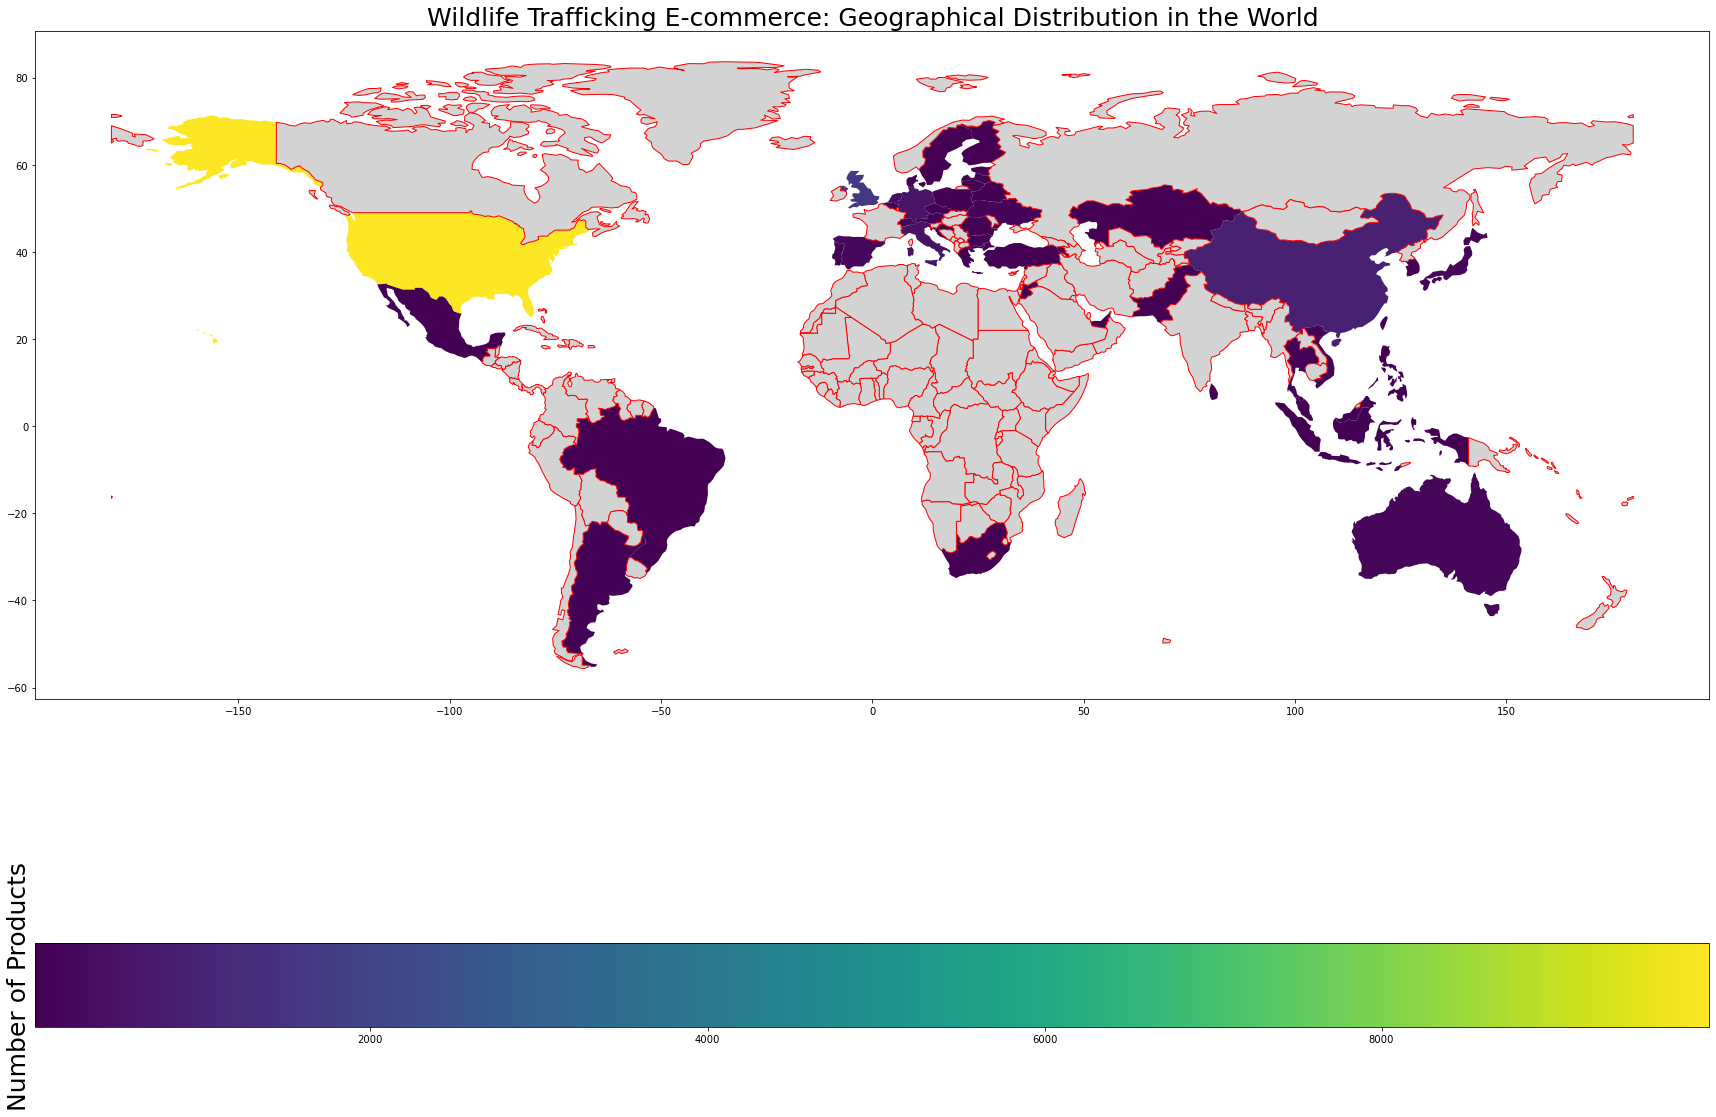

In [98]:
#Do the plot for the world
world = world.merge(df1, how="left", on="iso_a3")

#Remove Antarctica since no sellers there
world = world[world['iso_a3'] != 'ATA']

fig, ax = plt.subplots(1, 1, figsize=(30, 30))
world.plot(column='count', ax=ax, legend=True, cmap='viridis', 
           legend_kwds={ 'orientation': "horizontal"},
           missing_kwds={"color": "lightgrey", "edgecolor": "red"})

ax.set_title("Wildlife Trafficking E-commerce: Geographical Distribution in the World", fontsize=25)

cax = ax.get_figure().get_axes()[1]
cax.set_ylabel("Number of Products", fontsize=25)

plt.show()


In [32]:
#Now, analyze the geographical distribution in US
view = spark.sql("""
    SELECT 
    country_code as state_code, 
    count 
FROM 
    country_count_view
WHERE country_code IN ('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 
                              'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 
                              'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 
                              'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
                              'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY') 
ORDER BY 
    count DESC
    """)
view.createOrReplaceTempView("view")
view_2 = spark.sql("SELECT * FROM view")
view_2.show(10)

+----------+-----+
|state_code|count|
+----------+-----+
|        NY| 1147|
|        CA| 1121|
|        FL|  630|
|        DE|  549|
|        TX|  342|
|        PA|  196|
|        CT|  145|
|        OH|  144|
|        IL|  141|
|        NJ|  126|
|        MA|  118|
|        GA|  114|
|        AR|   74|
|        CO|   68|
|        IN|   65|
|        AZ|   57|
|        NC|   56|
|        OR|   50|
|        MI|   49|
|        WI|   47|
|        MD|   39|
|        ID|   39|
|        VA|   39|
|        MO|   31|
|        NV|   26|
|        LA|   19|
|        TN|   14|
|        KY|   13|
|        NM|   12|
|        OK|   11|
|        SC|   10|
+----------+-----+



In [76]:
import geopandas as gpd

# Path to the shapefile
shapefile_path = '/home/yl6644_nyu_edu/project/cb_2018_us_state_500k.shp'

# Read the shapefile
us_states = gpd.read_file(shapefile_path)


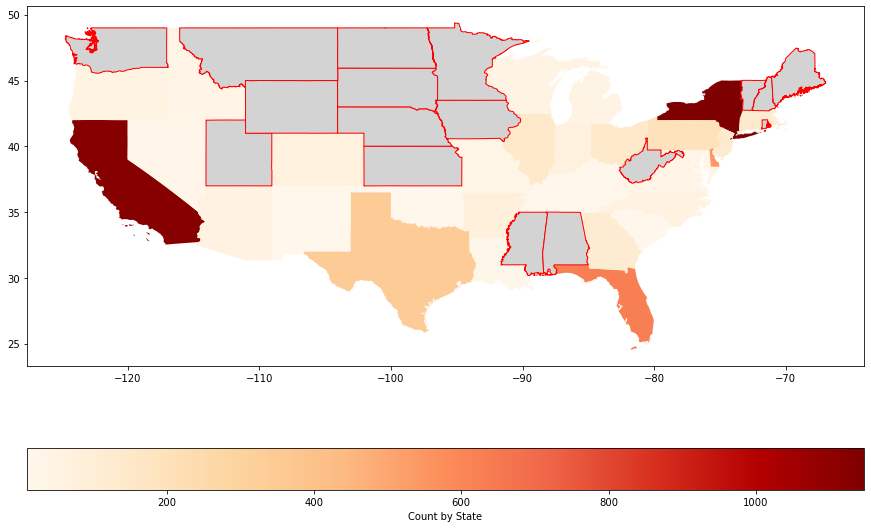

In [81]:
view_2_pandas = view_2.toPandas()

# Make sure to use the correct column for merging.
# For example, if the shapefile's state abbreviation column is named 'STUSPS':
us_states = us_states.merge(view_2_pandas, how="left", left_on="STUSPS", right_on="state_code")

# Plotting the heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
us_states.plot(column='count', ax=ax, legend=True, cmap='OrRd', 
               legend_kwds={'label': "Count by State", 'orientation': "horizontal"},
               missing_kwds={"color": "lightgrey", "edgecolor": "red"})
plt.show()